<div style="width: 1350px; height: 30px; background-color: green;"></div>


# TO DO

##### **Cross Validation**
- Currently, we are using cross-entropy for the criterion, but according to ChatGPT, it has nothing to do with cross-validation, and I think that makes sense.
- We want to use cross-validation to somehow max the F1 score
  - We are minimizing loss, but somehow we want to maximize F1 score during cross validation (see feedback Project 1)
  - Currently the `train_acc_history` doesn't work well. At each epoch it returns the acc for ALL minibatches. Therefore, at the end of the 5 epochs instead of containing 5 values, it contains 20 (5 epochs x 4 minibatches). I think that with cross-validation we have to take the average of them ??

##### **Other**
- Parameter tuning: get cool hyperparameters (criterion, number of epochs, optimizer, scheduler)
- Data Augmentation: transformations (rotations, translations, cutouts, zoom in, zoom out...)
- Multimodal data: currently we only train the image itself. Maybe it's useful to train other parameters such as the date or the location, as Sophie said that if a jet occurs in a location, it is more likely that another jet occurs in that same location.
- Batch size set to 32. Change it?

##### **Model Testing**
- We have to divide data into training, validation, and test. BUT, as we are using cross validation we don't need the validation set I think???
- Need to evaluate and test model

##### **Network Model**
- I didn't include the first two layers from the paper (input layer and BRN). Should we? CAREFUL AS THIS MAY REBOOT THE LAPTOP
- Batch **re**normalization ?
- Part of me thinks that this model is better when we have small images but with a lot of samples, because using 127 datapoints (which is low but not that low), it only takes 2 min to run even when running on CPU, which seems like so little time.

<div style="width: 1350px; height: 30px; background-color: green;"></div>


# 0. Load Modules

In [1]:
# Main libraries used all the time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Operating system libraries
import os
import sys

# Machine learning libraries
import torch
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.transforms import v2 # library to define the transforms

!pip install torcheval  # needs to run on google colab, on local machine you can just "pip install torcheval" in the terminal
from torcheval.metrics.functional import multiclass_f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.6 MB/s eta 0:00:00


In [2]:
# For Google Colab, mount Google Drive, for local environments, get local path (github)

# Change with the appropriate path. Log in into Drive and create the folders with the data

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    # Carlos
    #folder0_path = '/content/drive/My Drive/solar_jets/data0'
    #folder0_test_path = '/content/drive/My Drive/solar_jets/data0_test'
    #folder1_path = '/content/drive/My Drive/solar_jets/data1'
    #folder1_test_path = '/content/drive/My Drive/solar_jets/data1_test'

    # Julie
    folder0_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0'
    folder1_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1'
    folder0_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0_test'
    folder1_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_test'
else:
    # For local environments like VS Code
    folder0_path = './data0'
    folder1_path = './data1'
    folder0_test_path = './data0_test'
    folder1_test_path = './data1_test'

Mounted at /content/drive


# 1. Very naive Model

## 1.1. Prepare the dataset

#### Create the class

In [3]:
class NPZDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir

        # in self.files, only add f if it has 30 samples
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.transform = transform

    # Check if the file has 30 samples, if not, don't include it in self.files (see above)
    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)['arr_0']

        # Rearrange dimensions to (30, 166, 166) for PyTorch (insted of (166, 166, 30))
        data = np.moveaxis(data, -1, 0)

        # assign label 1 if data is from data1, 0 if from data0
        label = 1.0 if 'data1' in self.data_dir else 0.0
        return torch.from_numpy(data).float(), label

### Define the transforms that we want to apply

In [41]:
mean = 51.6644
std = 62.7087

train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #equivalent to transforms.ToTensor()
    v2.Normalize((mean,), (std,)),
    #v2.RandomResizedCrop(size=(140, 140)),
    #v2.RandomAffine(degrees=(-90,90), translate=(0.3, 0.3), scale=(0.8, 1.2))
    # add other transforms if needed
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #equivalent to transforms.ToTensor()
    v2.Normalize((mean,), (std,)),
])

#### Run to get the Data

The data was randomly separated into training and test, and put into separated folders. We are using 80% for training and 20% for testing. Notice that we don't use the same transforms on the train and test dataset.

In [42]:
train_data1 = NPZDataset(folder1_path, transform=train_transform)
train_data0 = NPZDataset(folder0_path, transform=train_transform)
train_data = torch.utils.data.ConcatDataset([train_data1, train_data0])

test_data1 = NPZDataset(folder1_test_path, transform=test_transform)
test_data0 = NPZDataset(folder0_test_path, transform=test_transform)
test_data = torch.utils.data.ConcatDataset([test_data1, test_data0])



Calculate mean and std for v2.Normalize() (doesn't need to run anymore as the values have been entered above)

In [ ]:

# Calculate mean and std
mean = torch.zeros(1)  # Assuming your images are RGB, change 3 to 1 for grayscale images
std = torch.zeros(1)

for i in range(len(train_data)):
    sequence, _ = train_data[i]

    # Make sure the image is a PyTorch tensor
    if not isinstance(sequence, torch.Tensor):
        sequence = transforms.ToTensor()(sequence)

    # Accumulate mean and std
    mean += torch.mean(sequence)
    std += torch.std(sequence)

# Calculate mean and std across the dataset
mean /= len(train_data)
std /= len(train_data)

print("Mean:", mean)
print("Std:", std)

Mean: tensor([52.4797])
Std: tensor([63.5925])


Below we'll see how train_data can be treated just like lists

- One element in the list for each sequence of images
- Each element of the list has a tuple of two elements, the first the array (166,30,30) and the second the label

In [6]:
print("Total training samples: ",len(train_data))
print("Total testing samples: ", len(test_data))



Total training samples:  1384
Total testing samples:  345


In [ ]:
print(f"Sample {0}: Shape {train_data1[0][0].shape}, Label: {train_data1[0][1]}")
print(f"Sample {0}: Shape {train_data0[0][0].shape}, Label: {train_data0[0][1]}")


Sample 0: Shape torch.Size([30, 166, 166]), Label: 1.0
Sample 0: Shape torch.Size([30, 166, 166]), Label: 0.0


#### Get the Minibatch
for training and testing

In [43]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


See that we have 42 different minibatches, each with 32 samples

In [ ]:
for i, (x, y) in enumerate(train_loader):
    print(f"Batch {i}: samples {x.shape[0]}")


Batch 0: samples 32
Batch 1: samples 32
Batch 2: samples 32
Batch 3: samples 32
Batch 4: samples 32
Batch 5: samples 32
Batch 6: samples 32
Batch 7: samples 32
Batch 8: samples 32
Batch 9: samples 32
Batch 10: samples 32
Batch 11: samples 32
Batch 12: samples 32
Batch 13: samples 32
Batch 14: samples 32
Batch 15: samples 32
Batch 16: samples 32
Batch 17: samples 32
Batch 18: samples 32
Batch 19: samples 32
Batch 20: samples 32
Batch 21: samples 32
Batch 22: samples 32
Batch 23: samples 32
Batch 24: samples 32
Batch 25: samples 32
Batch 26: samples 32
Batch 27: samples 32
Batch 28: samples 32
Batch 29: samples 32
Batch 30: samples 32
Batch 31: samples 32
Batch 32: samples 32
Batch 33: samples 32
Batch 34: samples 32
Batch 35: samples 32
Batch 36: samples 32
Batch 37: samples 32
Batch 38: samples 32
Batch 39: samples 32
Batch 40: samples 32
Batch 41: samples 32
Batch 42: samples 32
Batch 43: samples 8


# Model 1 from "Deep Learning for Image Sequence Classification of Astronomical Events" - Recurrent neural network

# 2. Define the Neural Network

In [7]:
class RCNN(torch.nn.Module):

    def __init__(self):
        super(RCNN, self).__init__()

        # Define the layers

        # 1. Input layers
        #self.input_layer=torch.nn.Linear(in_features=166*166*30, out_features=166*166*30)      # not sure if this is needed
        #self.norm=torch.nn.BatchNorm2d(166*166*30)        #not sure this is sufficent for batch renormalization

        # 2. Convolutional layers

        # Three conv layers
        # according to gpt, in_channels=1 because in the sequence, it is still gray scale, not rgb
        self.conv1 = self.create_conv_layer(in_channels=30, out_channels=64)
        self.conv2 = self.create_conv_layer(in_channels=64, out_channels=64)
        self.conv3 = self.create_conv_layer(in_channels=64, out_channels=64)

        # First maxpool
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2,stride=2)

        # Three conv layers
        self.conv4 = self.create_conv_layer(in_channels=64, out_channels=64)
        self.conv5 = self.create_conv_layer(in_channels=64, out_channels=64)
        self.conv6 = self.create_conv_layer(in_channels=64, out_channels=64)

        # Second maxpool
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2,stride=2)

        # Flatten
        self.flatten=torch.nn.Flatten()

        # Each time we apply pooling, height and width are divided by 2
        self.flat_size = 64 * int(np.floor(166/2/2)) * int(np.floor(166/2/2))

        # Fully connected with dropout
        self.lin=torch.nn.Linear(self.flat_size, 1024)
        self.drop=torch.nn.Dropout(p=0.5)

        #LSTM
        # we set batch_first=True to have batch_size as first dimension: (30,166,166)
        self.lstm = torch.nn.LSTM(input_size=1024, hidden_size=512, num_layers=1, batch_first=True)

        #output: for binary classification softmax is not needed
        #self.output_layer=torch.nn.Softmax(dim=1)
        self.output = torch.nn.Linear(512, 1)

    # To make the code more clear, let's use this function to create conv layers
    def create_conv_layer(self, in_channels, out_channels):
        conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        relu = torch.nn.ReLU()
        norm = torch.nn.BatchNorm2d(out_channels)
        return torch.nn.Sequential(conv, relu, norm)



    def forward(self, x):

        # Define the forward pass

        # 1. Input layers
        #x=self.input_layer(x)
        #x=self.norm(x)

        # 2. Convolutional layers
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)

        # First maxpool
        x=self.pool1(x)

        # Three conv layers
        x=self.conv4(x)
        x=self.conv5(x)
        x=self.conv6(x)

        # Second maxpool
        x=self.pool2(x)

        # Flatten
        x=self.flatten(x)

        # Fully connected with dropout
        x=self.lin(x)
        x=self.drop(x)

        #LSTM
        #x = x.view(x.size(0), -1, self.flat_size)
        #x = x.view(x.size(0), 30, -1)
        lstm_out, _ = self.lstm(x)
        #lstm_out = lstm_out[:, -1, :]

        #output
        out=self.output(lstm_out)

        return out.view(-1)

#### Define the model

In [9]:
model = RCNN()

# Model 2 from "Fast Solar Image Classification Using Deep Learning and its Importance for Automation in Solar Physics" - Convolutional neural network


In [44]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        ## Convolution layers

        # 2 conv 64 + max pool
        self.conv1 = self.create_conv_layer(in_channels=30, out_channels=64)
        self.conv2 = self.create_conv_layer(in_channels=64, out_channels=64)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2,stride=2)

        # 2 conv 128 + max pool
        self.conv3 = self.create_conv_layer(in_channels=64, out_channels=128)
        self.conv4 = self.create_conv_layer(in_channels=128, out_channels=128)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2,stride=2)

        # 2 conv 256 + max pool
        self.conv5 = self.create_conv_layer(in_channels=128, out_channels=256)
        self.conv6 = self.create_conv_layer(in_channels=256, out_channels=256)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2,stride=2)

        # 2 conv 512 + max pool
        self.conv7 = self.create_conv_layer(in_channels=256, out_channels=512)
        self.conv8 = self.create_conv_layer(in_channels=512, out_channels=512)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2,stride=2)

        # 2 conv 512 + max pool
        self.conv9 = self.create_conv_layer(in_channels=512, out_channels=512)
        self.conv10 = self.create_conv_layer(in_channels=512, out_channels=512)
        self.pool5 = torch.nn.MaxPool2d(kernel_size=2,stride=2)

        ## Fully connected layers

        # linear + ReLU + dropot (p=0.5)
        self.linear1 = torch.nn.Linear(in_features=512*5*5, out_features=1600)
        self.R1 = torch.nn.ReLU()
        self.DO1 = torch.nn.Dropout(p=0.5)

        # linear + ReLU + dropot (p=0.5)
        self.linear2 = torch.nn.Linear(in_features=1600, out_features=1600)
        self.R2 = torch.nn.ReLU()
        self.DO2 = torch.nn.Dropout(p=0.5)

        # Final linear layer
        self.linear3 = torch.nn.Linear(in_features=1600, out_features=2)
        self.sm = torch.nn.Softmax()


        # To make the code more clear, let's use this function to create conv layers
    def create_conv_layer(self, in_channels, out_channels):
        conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        norm = torch.nn.BatchNorm2d(out_channels)
        relu = torch.nn.ReLU()
        return torch.nn.Sequential(conv, norm, relu)


    def forward(self, x):

        # Define the forward pass
        ## Convolution layers
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.pool1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool3(x)

        x = self.conv7(x)
        x = self.conv8(x)
        x = self.pool4(x)

        x = self.conv9(x)
        x = self.conv10(x)
        x = self.pool5(x)
        x = x.view(x.size(0), -1)

        ## Fully connected layers
        x = self.linear1(x)
        x = self.R1(x)
        x = self.DO1(x)

        x = self.linear2(x)
        x = self.R2(x)
        x = self.DO2(x)

        x = self.linear3(x)

        return x

In [45]:
model = CNN()

# 3. Training Parameters

There is a lot that can be done here to get very cool hyperparameters

In [63]:
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCEWithLogitsLoss()


num_epochs = 20

#optimizer = torch.optim.AdamW(model.parameters())
optimizer = torch.optim.SGD(model.parameters(),lr=0.1,momentum=0.9,nesterov=True) # as seen in paper, needs to be improved/adapted

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

# 4. Train Epoch Script

In [52]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    model.train()
    loss_history = []
    accuracy_history = []
    lr_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.float().to(device), target.float().to(device)
        optimizer.zero_grad()
        output = model(data)

        argmax_output = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(True) # weird but equivalent to torch.tensor(...)
        loss = criterion(argmax_output, target)

        loss.backward()
        optimizer.step()
        scheduler.step()

        pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)

        correct = pred.eq(target.view_as(pred)).sum().item()
        loss_float = loss.item()
        accuracy_float = correct / len(data)

        loss_history.append(loss_float)
        accuracy_history.append(accuracy_float)
        lr_history.append(scheduler.get_last_lr()[0])

        # this is the if statement of the lab, but it doesn't work for me. it makes no sense to me tbh
        #if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
        # this doesn't work bad, but it just prints the last batch of the epoch
        """
        if batch_idx == len(train_loader) - 1:
            print(
                f"* Train Epoch: {epoch}-{batch_idx:03d} \n"
                f"batch_loss={loss_float:0.2e} "
                f"batch_acc={accuracy_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} \n"
            )
      """
    epoch_accuracy = np.sum(accuracy_history) / len(train_loader)
    epoch_loss = np.sum(loss_history) / len(train_loader)
    print(f"* Train Epoch: {epoch} \n"
          f"average accuracy = {100. * epoch_accuracy:.2f}")

    return loss_history, accuracy_history, lr_history

# 5. Test Script

In [66]:
@torch.no_grad()
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)
            #pred = torch.tensor(torch.argmax(output, dim=1).float(), requires_grad=False)

            test_loss += criterion(pred, target)  # sum up batch loss
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    print(f'* Test set: \n Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * test_accuracy:.2f}%)\n')
    return test_loss, test_accuracy


### Compute the F1 score for the whole data

In [54]:
@torch.no_grad()
def compute_f1(model, device, test_loader):
    model.eval()
    batch_f1 = np.zeros(len(test_loader))

    for batch_idx, (data, target) in enumerate(test_loader):    # iterate over each minibatch
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)

        batch_f1[batch_idx] = multiclass_f1_score(pred, target, num_classes=2)   # compute the F1 score for 1 minibatch

    f1_score = np.sum(batch_f1) / len(test_loader)  # Output is the average of the f1 score over all minibatches

    return f1_score

# 6. Train the Network 😀😀😀😀😀


In [65]:
# Training History
lr_history = []
train_loss_history = []
train_acc_history = []

# Validation History
val_loss_history = []
val_acc_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
i = 1

for epoch in range(1, num_epochs + 1):
    print(f" === Training starting for epoch {i} / {num_epochs} === \n")
    train_loss, train_acc, lrs = train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device)
    train_loss_history.extend(train_loss)
    train_acc_history.extend(train_acc)
    lr_history.extend(lrs)

    # Test the model after each epoch
    test_loss, test_accuracy = test_model(model, test_loader, criterion, device)
    val_loss_history.append(test_loss)
    val_acc_history.append(test_accuracy)
    i += 1

f1_score = compute_f1(model, device, test_loader)

print(f"Final F1 score: {f1_score:.4f}")


 === Training starting for epoch 1 / 20 === 

* Train Epoch: 1 
average accuracy = 0.5262784090909091
* Test set: 
 Average loss: 0.0259, Accuracy: 175/345 (50.72%)

 === Training starting for epoch 2 / 20 === 

* Train Epoch: 2 
average accuracy = 0.5234375
* Test set: 
 Average loss: 0.0259, Accuracy: 176/345 (51.01%)

 === Training starting for epoch 3 / 20 === 

* Train Epoch: 3 
average accuracy = 0.5220170454545454
* Test set: 
 Average loss: 0.0259, Accuracy: 175/345 (50.72%)

 === Training starting for epoch 4 / 20 === 

* Train Epoch: 4 
average accuracy = 0.5056818181818182
* Test set: 
 Average loss: 0.0258, Accuracy: 178/345 (51.59%)

 === Training starting for epoch 5 / 20 === 

* Train Epoch: 5 
average accuracy = 0.515625
* Test set: 
 Average loss: 0.0259, Accuracy: 177/345 (51.30%)

 === Training starting for epoch 6 / 20 === 

* Train Epoch: 6 
average accuracy = 0.49644886363636365
* Test set: 
 Average loss: 0.0258, Accuracy: 179/345 (51.88%)

 === Training starting

In [67]:
print("learning rate", lr_history)
print("train loss", train_loss_history)
print("train accuracy", train_acc_history)
print("test loss", val_loss_history)
print("test accuracy", val_acc_history)

learning rate [0.09993537954068375, 0.09992582071507215, 0.09991560333413534, 0.09990472753264745, 0.09989319345406766, 0.0998810012505383, 0.09986815108288273, 0.09985464312060338, 0.09984047754187937, 0.09982565453356429, 0.09981017429118363, 0.09979403701893226, 0.09977724292967169, 0.09975979224492734, 0.0997416851948855, 0.09972292201839042, 0.0997035029629411, 0.09968342828468799, 0.09966269824842969, 0.09964131312760935, 0.0996192732043112, 0.09959657876925672, 0.09957323012180083, 0.099549227569928, 0.09952457143024811, 0.0994992620279923, 0.0994732996970087, 0.09944668477975802, 0.09941941762730898, 0.0993914985993338, 0.09936292806410328, 0.09933370639848212, 0.09930383398792385, 0.09927331122646574, 0.09924213851672366, 0.09921031626988672, 0.09917784490571188, 0.09914472485251835, 0.09911095654718206, 0.09907654043512978, 0.09904147697033328, 0.09900576661530336, 0.09896940984108374, 0.09893240712724488, 0.09889475896187755, 0.09885646584158653, 0.09881752827148393, 0.09877

! learning rate is weird !

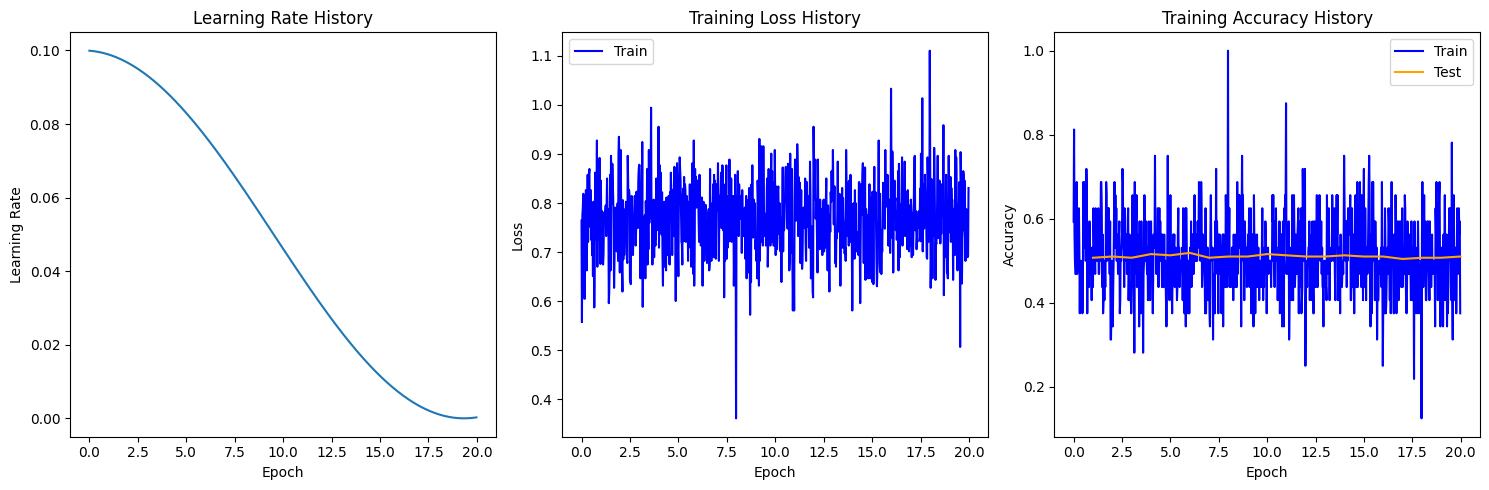

In [68]:
n_train = len(train_acc_history)
t_train = num_epochs * np.arange(n_train) / n_train
t_test = np.arange(1, num_epochs + 1)


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting learning rate history
axs[0].plot(t_train, lr_history)
axs[0].set_title('Learning Rate History')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Learning Rate')

# Plotting training loss history
axs[1].plot(t_train, train_loss_history, color='b', label="Train")
#axs[1].plot(t_test, val_loss_history, label="Test", color='orange')
axs[1].legend()
axs[1].set_title('Training Loss History')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

# Plotting training accuracy history
axs[2].plot(t_train, train_acc_history, color='b', label="Train")
axs[2].plot(t_test, val_acc_history, label="Test", color='orange')
axs[2].legend()
axs[2].set_title('Training Accuracy History')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

plt.show()

# 5. Introduce a parameter selection function

We want as output of the model:
- f1 score as fctn of criterion + optimizer + scheduler
- f1 score as fctn of the epoch?

- test different models in this function as well??

and then later, we will compute the learning rate, accuracy and loss for the optimal parameters to make the graphs

=> needs improvements, not sure all hyperparameters can be well combined

In [ ]:
def param_selection(model, device, criterions, optimizers, schedulers, num_epochs, test_loader):
    a = len(criterions)
    b = len(optimizers)
    c = len(schedulers)
    n_combi = a*b*c

    all_f1, crilog, optilog, schedlog = [], [], [], []

    for i, criterion in enumerate(criterions):
        for j, optimizer in enumerate(optimizers):
            for k, scheduler in enumerate(schedulers):

                print("===============================================")
                print(f"Round {i*j*k+1} of {n_combi} \n * criterion: {criterion} \n * optmizer: {optimizer} \n * scheduler: {scheduler}")
                print("===============================================")

                # Keep a record of the hyperparameters we are using
                crilog.append(criterion)
                optilog.append(optimizer)
                schedlog.append(scheduler)

                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                model.to(device)

                # Training
                for epoch in range(1, num_epochs + 1):
                    train_loss, train_acc, lrs = train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device)

                # Compute f1 score for this combination of hyperparameters and store it
                f1_score = compute_f1(model, device, test_loader)
                all_f1.append(f1_score)

                best = max(all_f1)
                best_idx = all_f1.index(best)

                optimal_param = [crilog[best_idx], optilog[best_idx], schedlog[best_idx]]


    return criterions, optimizers, schedulers, all_f1, optimal_param

Define the hyperparameters to test

In [ ]:
num_epochs = 1
criterions = [torch.nn.CrossEntropyLoss()]
optimizers = [torch.optim.AdamW(model.parameters())]
schedulers = [torch.optim.lr_scheduler.CosineAnnealingLR(torch.optim.AdamW(model.parameters()),T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,)]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Run the function

In [ ]:
criterions, optimizers, schedulers, all_f1, optimal_param = param_selection(model, device, criterions, optimizers, schedulers, num_epochs, test_loader)
print("F1 score: ", all_f1)

Cross-validation round 1 of 1 
 * criterion: CrossEntropyLoss() 
 * optmizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
) 
 * scheduler: <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x17659ca60>


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train Epoch: 1-042 batch_loss=3.75e+01 batch_acc=0.478 lr=1.398e-06 


/var/folders/7l/ltdxzx1s3dj_sz2kw6_5g8k00000gn/T/ipykernel_9264/2011082625.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor((output >= 0.5).float())


F1 score:  [0.5443181883205067]


# 7. Analyze the output of parameter selection